# **1. Import Library**

In [1]:
import pandas as pd
import numpy as np
import json
import os
import re
import warnings
import pickle
import joblib

warnings.filterwarnings('ignore')

# Preprocessing Libraries
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Scikit-learn Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, classification_report, confusion_matrix)

# Imbalanced-learn
from imblearn.over_sampling import SMOTE

# Gensim
from gensim.models import Word2Vec

# TensorFlow/Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Embedding, Conv1D, 
                                      GlobalMaxPooling1D, LSTM, Bidirectional)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# XGBoost
from xgboost import XGBClassifier

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# **2. Memuat Dataset**

In [2]:
dataset_path = r"D:\Perkuliahan\Asah led by Dicoding\Asah_Proyek Analisis Sentimen\gojek_reviews_v2.csv"
df = pd.read_csv(dataset_path)

In [3]:
df.head()

,userName,score,content,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,Diki Fiki,5,saya suka dengan aplikasi ini .mudah dan prakt...,0,5.35.1,2025-10-12 21:52:12,NaN,NaN
1,Bro Dull,5,"hallo kak, bisakah adakan label halal untuk pr...",0,5.33.1,2025-10-12 21:49:36,NaN,NaN
2,Epick konten,5,banyak Promo cepat transaksinya,0,5.32.1,2025-10-12 21:41:49,NaN,NaN
3,Amalia Laila,3,tolong dong buat gojek buat nyediain kembalian...,0,NaN,2025-10-12 21:38:07,"Hai Kak Amalia, mohon maaf atas ketidaknyamana...",2025-10-12 22:05:26
4,Rahmawati Hidayat,2,"saya komplain makanan yg saya pesan berbeda, s...",0,NaN,2025-10-12 21:19:27,"Hai Kak Rahmawati, mohon maaf atas ketidaknyam...",2025-10-12 21:50:24


In [4]:
# Cek missing value
df.isnull().sum()

userName                   0
score                      0
content                    0
thumbsUpCount              0
reviewCreatedVersion    2687
at                         0
replyContent            8645
repliedAt               8645
dtype: int64

In [5]:
# Drop kolom yang tidak digunakan
df = df.drop(columns=['userName', 'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent', 'repliedAt'])
df.head()

,score,content
0,5,saya suka dengan aplikasi ini .mudah dan prakt...
1,5,"hallo kak, bisakah adakan label halal untuk pr..."
2,5,banyak Promo cepat transaksinya
3,3,tolong dong buat gojek buat nyediain kembalian...
4,2,"saya komplain makanan yg saya pesan berbeda, s..."


# **3. Preprocessing**

In [6]:
# Fungsi untuk preprocessing
def preprocess_text(text):
    text = str(text).lower()

    # Hapus emoji
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "\U00002702-\U000027B0"
        "\U000024C2-\U0001F251"
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002600-\U000026FF"  # Miscellaneous Symbols
        "\U00002700-\U000027BF"
        "]+", flags=re.UNICODE
    )
    text = emoji_pattern.sub(r'', text)

    # Hapus emoticon teks 
    text = re.sub(r'[:;=][oO\-]?[D\)\]\(\]/\\OpP]', '', text)
    
    text = re.sub(r'http\S+|www\S+', '', text)  # Hapus URL
    text = re.sub(r'@\w+', '', text)  # Hapus mention
    text = re.sub(r'#\w+', '', text)  # Hapus hashtag
    text = re.sub(r'\d+', '', text)  # Hapus angka
    text = re.sub(r'[^\w\s]', '', text)  # Hapus tanda baca
    text = re.sub(r'\s+', ' ', text).strip()  # Hapus spasi berlebih
    return text

## 3.1 Case Folding dan Cleaning

In [7]:
# Case folding dan cleaning
df['text_cleaned'] = df['content'].apply(preprocess_text)
df.head()

,score,content,text_cleaned
0,5,saya suka dengan aplikasi ini .mudah dan prakt...,saya suka dengan aplikasi ini mudah dan praktis
1,5,"hallo kak, bisakah adakan label halal untuk pr...",hallo kak bisakah adakan label halal untuk pro...
2,5,banyak Promo cepat transaksinya,banyak promo cepat transaksinya
3,3,tolong dong buat gojek buat nyediain kembalian...,tolong dong buat gojek buat nyediain kembalian...
4,2,"saya komplain makanan yg saya pesan berbeda, s...",saya komplain makanan yg saya pesan berbeda sa...


## 3.2 Stopword

In [8]:
# Stopword
stopword_remover = StopWordRemoverFactory().create_stop_word_remover()

df['text_no_stopword'] = df['text_cleaned'].apply(lambda x: stopword_remover.remove(x))
df.head()

,score,content,text_cleaned,text_no_stopword
0,5,saya suka dengan aplikasi ini .mudah dan prakt...,saya suka dengan aplikasi ini mudah dan praktis,suka aplikasi mudah praktis
1,5,"hallo kak, bisakah adakan label halal untuk pr...",hallo kak bisakah adakan label halal untuk pro...,hallo kak bisakah adakan label halal produk go...
2,5,banyak Promo cepat transaksinya,banyak promo cepat transaksinya,banyak promo cepat transaksinya
3,3,tolong dong buat gojek buat nyediain kembalian...,tolong dong buat gojek buat nyediain kembalian...,dong buat gojek buat nyediain kembalian karna ...
4,2,"saya komplain makanan yg saya pesan berbeda, s...",saya komplain makanan yg saya pesan berbeda sa...,komplain makanan yg pesan berbeda menghubungi ...


## 3.3 Stemming

In [9]:
# Stemmer
stemmer = StemmerFactory().create_stemmer()

df['clean_text'] = df['text_no_stopword'].apply(lambda x: stemmer.stem(x))
df.head()

,score,content,text_cleaned,text_no_stopword,clean_text
0,5,saya suka dengan aplikasi ini .mudah dan prakt...,saya suka dengan aplikasi ini mudah dan praktis,suka aplikasi mudah praktis,suka aplikasi mudah praktis
1,5,"hallo kak, bisakah adakan label halal untuk pr...",hallo kak bisakah adakan label halal untuk pro...,hallo kak bisakah adakan label halal produk go...,hallo kak bisa adakan label halal produk gofoo...
2,5,banyak Promo cepat transaksinya,banyak promo cepat transaksinya,banyak promo cepat transaksinya,banyak promo cepat transaksi
3,3,tolong dong buat gojek buat nyediain kembalian...,tolong dong buat gojek buat nyediain kembalian...,dong buat gojek buat nyediain kembalian karna ...,dong buat gojek buat nyediain kembali karna ga...
4,2,"saya komplain makanan yg saya pesan berbeda, s...",saya komplain makanan yg saya pesan berbeda sa...,komplain makanan yg pesan berbeda menghubungi ...,komplain makan yg pesan beda hubung cs tp laya...


# **4. Pelabelan Sentimen Menggunakan Lexicon-Based**

In [10]:
lexicon_positive = {
    'bagus': 1, 'baik': 1, 'senang': 1, 'puas': 1, 'suka': 1, 'cepat': 1,
    'mantap': 1, 'aman': 1, 'nyaman': 1, 'ramah': 1, 'murah': 1, 'lancar': 1,
    'recommended': 1, 'terbaik': 1, 'hebat': 1, 'sempurna': 1, 'cinta': 1,
    'sukses': 1, 'joss': 1, 'top': 1, 'memuaskan': 1, 'mudah': 1
}

lexicon_negative = {
    'buruk': -1, 'jelek': -1, 'kecewa': -1, 'lambat': -1, 'mahal': -1,
    'lama': -1, 'susah': -1, 'ribet': -1, 'error': -1, 'gagal': -1,
    'batal': -1, 'masalah': -1, 'parah': -1, 'hancur': -1, 'benci': -1,
    'rugi': -1, 'zonk': -1, 'php': -1, 'lemot': -1, 'sampah': -1,
    'tidak': -0.5, 'kurang': -0.5, 'belum': -0.5
}

# Gabungkan lexicon
lexicon = {**lexicon_positive, **lexicon_negative}

print(f"📚 Jumlah kata dalam lexicon: {len(lexicon)} kata")
print(f"   - Positif: {len(lexicon_positive)} kata")
print(f"   - Negatif: {len(lexicon_negative)} kata")
print("\n")

def calculate_sentiment_score(text):
    words = text.split()
    score = 0
    
    for i, word in enumerate(words):
        if word in lexicon:
            if i > 0 and words[i-1] in ['tidak', 'kurang', 'belum', 'jangan']:
                score -= lexicon[word]
            else:
                score += lexicon[word]
    
    return score

def label_sentiment(score):
    """
    Konversi skor ke label 3 kelas
    """
    if score > 0:
        return 'positif'
    elif score < 0:
        return 'negatif'
    else:
        return 'netral'
    
# Apply lexicon-based labeling
df['sentiment_score'] = df['clean_text'].apply(calculate_sentiment_score)
df['label_lexicon'] = df['sentiment_score'].apply(label_sentiment)

# Tampilkan hasil labeling
df.head(10)

📚 Jumlah kata dalam lexicon: 45 kata
   - Positif: 22 kata
   - Negatif: 23 kata




,score,content,text_cleaned,text_no_stopword,clean_text,sentiment_score,label_lexicon
0,5,saya suka dengan aplikasi ini .mudah dan prakt...,saya suka dengan aplikasi ini mudah dan praktis,suka aplikasi mudah praktis,suka aplikasi mudah praktis,2.0,positif
1,5,"hallo kak, bisakah adakan label halal untuk pr...",hallo kak bisakah adakan label halal untuk pro...,hallo kak bisakah adakan label halal produk go...,hallo kak bisa adakan label halal produk gofoo...,0.0,netral
2,5,banyak Promo cepat transaksinya,banyak promo cepat transaksinya,banyak promo cepat transaksinya,banyak promo cepat transaksi,1.0,positif
3,3,tolong dong buat gojek buat nyediain kembalian...,tolong dong buat gojek buat nyediain kembalian...,dong buat gojek buat nyediain kembalian karna ...,dong buat gojek buat nyediain kembali karna ga...,0.0,netral
4,2,"saya komplain makanan yg saya pesan berbeda, s...",saya komplain makanan yg saya pesan berbeda sa...,komplain makanan yg pesan berbeda menghubungi ...,komplain makan yg pesan beda hubung cs tp laya...,-1.0,negatif
5,5,mantul👍,mantul,mantul,mantul,0.0,netral
6,3,"gembel lama banget buang"" waktu",gembel lama banget buang waktu,gembel lama banget buang waktu,gembel lama banget buang waktu,-1.0,negatif
7,1,sangat sangat kecewa dengan orderan go car ter...,sangat sangat kecewa dengan orderan go car ter...,sangat sangat kecewa orderan go car terakhir p...,sangat sangat kecewa order go car akhir pokok ...,-1.0,negatif
8,1,aplikasi ngak guna,aplikasi ngak guna,aplikasi ngak,aplikasi ngak,0.0,netral
9,1,"Gojek yg sekarang beda, turun kualitasnya di l...",gojek yg sekarang beda turun kualitasnya di le...,gojek yg sekarang beda turun kualitasnya level...,gojek yg sekarang beda turun kualitas level je...,-3.0,negatif


In [11]:
# Cek distribusi label
df['label_lexicon'].value_counts(normalize=True) * 100

netral     52.641667
positif    32.958333
negatif    14.400000
Name: label_lexicon, dtype: float64

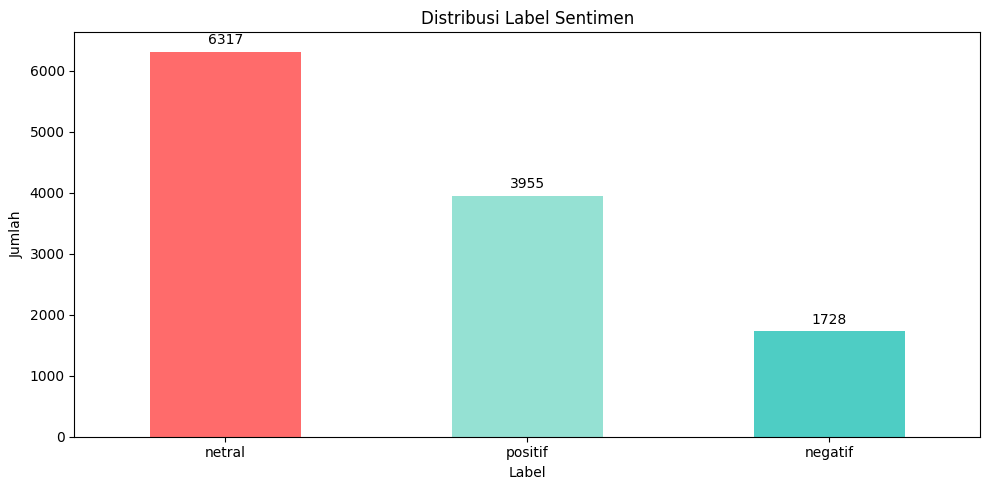

In [12]:
# visualisasi distribusi
plt.figure(figsize=(10, 5))

ax = df['label_lexicon'].value_counts().plot(kind='bar', color=['#ff6b6b', '#95e1d3', '#4ecdc4'])
plt.title('Distribusi Label Sentimen')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.xticks(rotation=0)

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10, padding=3)

plt.tight_layout()
plt.show()

# **5. Split Data**

In [13]:
X = df['clean_text']
y = df['label_lexicon']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Data Train: {len(X_train)} sampel")
print(f"Data Test: {len(X_test)} sampel")

Data Train: 9600 sampel
Data Test: 2400 sampel


# **6. Skema 1 (TF-IDF, SMOTE, DAN Random Forest)**

## 6.1 TF-IDF

In [14]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"TF-IDF Matrix Train: {X_train_tfidf.shape}")
print(f"TF-IDF Matrix Test: {X_test_tfidf.shape}")
print(f"Jumlah fitur (kata): {len(vectorizer.get_feature_names_out())}\n")

TF-IDF Matrix Train: (9600, 5000)
TF-IDF Matrix Test: (2400, 5000)
Jumlah fitur (kata): 5000



In [15]:
# Menampilkan top 20 kata dengan bobot tf-idf tertinggi
feature_names = vectorizer.get_feature_names_out()

# Hitung rata-rata TF-IDF tiap kata di semua dokumen training
avg_tfidf = np.asarray(X_train_tfidf.mean(axis=0)).ravel()

# Urutkan dari yang terbesar ke terkecil
sorted_indices = np.argsort(avg_tfidf)[::-1]

# Ambil top 20 kata
top_n = 20
top_words = [(feature_names[i], avg_tfidf[i]) for i in sorted_indices[:top_n]]

# Tampilkan hasil dalam DataFrame agar rapi
df_top = pd.DataFrame(top_words, columns=['Kata', 'Skor TF-IDF'])
print(df_top)

            Kata  Skor TF-IDF
0         mantap     0.049409
1          bagus     0.043337
2         sangat     0.032942
3          bantu     0.030315
4           good     0.028963
5           baik     0.025806
6   sangat bantu     0.022803
7          gojek     0.020998
8       aplikasi     0.018544
9         driver     0.017983
10           nya     0.015262
11           oke     0.014215
12         cepat     0.012887
13         mudah     0.012374
14         keren     0.011226
15            yg     0.010360
16            ga     0.009954
17        banget     0.009858
18         layan     0.009582
19         ramah     0.009320


In [16]:
# Buat DataFrame hasil top features
df_top = pd.DataFrame(top_words, columns=['Kata', 'Skor TF-IDF'])

top_indices = sorted_indices[:top_n]
tfidf_df = pd.DataFrame(
    X_train_tfidf.toarray()[:5, top_indices], 
    columns=[feature_names[i] for i in top_indices]
)

print("Cuplikan TF-IDF Matrix (5 Dokumen Pertama × 20 Fitur Teratas):")
print(tfidf_df)

Cuplikan TF-IDF Matrix (5 Dokumen Pertama × 20 Fitur Teratas):
   mantap  bagus  sangat  bantu  good      baik  sangat bantu  gojek  \
0     0.0    0.0     0.0    0.0   0.0  0.000000           0.0    0.0   
1     0.0    0.0     0.0    0.0   0.0  0.303018           0.0    0.0   
2     0.0    0.0     0.0    0.0   0.0  0.000000           0.0    0.0   
3     0.0    0.0     0.0    0.0   0.0  0.000000           0.0    0.0   
4     0.0    0.0     0.0    0.0   0.0  0.000000           0.0    0.0   

   aplikasi    driver       nya  oke     cepat  mudah  keren        yg   ga  \
0       0.0  0.000000  0.146662  0.0  0.000000    0.0    0.0  0.161869  0.0   
1       0.0  0.000000  0.000000  0.0  0.000000    0.0    0.0  0.000000  0.0   
2       0.0  0.113434  0.000000  0.0  0.000000    0.0    0.0  0.000000  0.0   
3       0.0  0.000000  0.167197  0.0  0.000000    0.0    0.0  0.000000  0.0   
4       0.0  0.000000  0.000000  0.0  0.375788    0.0    0.0  0.000000  0.0   

     banget     layan  ramah 

## 6.2 Menerapkan SMOTE

In [17]:
print("Distribusi sebelum SMOTE:")
print(y_train.value_counts())
print("\n")

# Inisialisasi SMOTE
min_class_count = y_train.value_counts().min()
k_neighbors = min(5, min_class_count - 1) if min_class_count > 1 else 1

smote = SMOTE(random_state=42, k_neighbors=k_neighbors)

X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

print("Distribusi setelah SMOTE:")
smote_dist = pd.Series(y_train_smote).value_counts()
print(smote_dist)
for label, count in smote_dist.items():
    print(f"   {label}: {count} ({count/len(y_train_smote)*100:.2f}%)")
print("\n")

print(f"Sebelum SMOTE: {X_train_tfidf.shape[0]} sampel")
print(f"Setelah SMOTE: {X_train_smote.shape[0]} sampel")

Distribusi sebelum SMOTE:
netral     5054
positif    3164
negatif    1382
Name: label_lexicon, dtype: int64


Distribusi setelah SMOTE:
netral     5054
positif    5054
negatif    5054
Name: label_lexicon, dtype: int64
   netral: 5054 (33.33%)
   positif: 5054 (33.33%)
   negatif: 5054 (33.33%)


Sebelum SMOTE: 9600 sampel
Setelah SMOTE: 15162 sampel


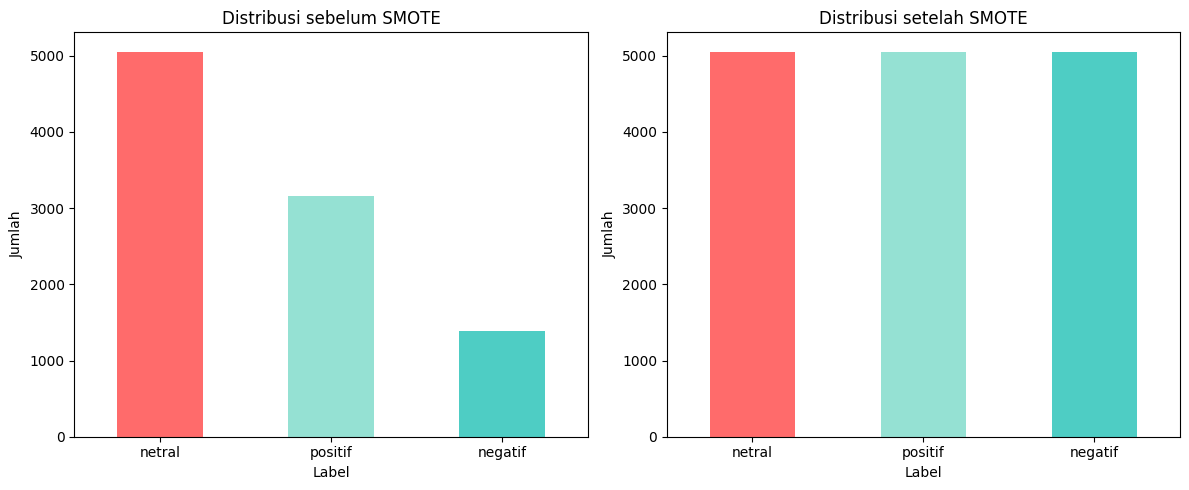

In [18]:
# Visualisasi perbandingan distribusi sebelum dan setelah SMOTE
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

y_train.value_counts().plot(kind='bar', ax=axes[0], color=['#ff6b6b', '#95e1d3', '#4ecdc4'])
axes[0].set_title('Distribusi sebelum SMOTE')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Jumlah')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

pd.Series(y_train_smote).value_counts().plot(kind='bar', ax=axes[1], color=['#ff6b6b', '#95e1d3', '#4ecdc4'])
axes[1].set_title('Distribusi setelah SMOTE')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Jumlah')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()

## 6.3 Modelling and Training (Random Forest)

In [19]:
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

print("Training Random Forest...")
rf_model.fit(X_train_smote, y_train_smote)

Training Random Forest...


RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=500, n_jobs=-1, random_state=42)

EVALUASI MODEL RANDOM FOREST (DATA TEST):
----------------------------------------------------------------------
Accuracy:  0.8767
Precision: 0.8999
Recall:    0.8767
F1-Score:  0.8835

Classification Report:
              precision    recall  f1-score   support

     negatif       0.60      0.86      0.70       346
      netral       0.93      0.87      0.90      1263
     positif       0.99      0.89      0.93       791

    accuracy                           0.88      2400
   macro avg       0.84      0.87      0.85      2400
weighted avg       0.90      0.88      0.88      2400



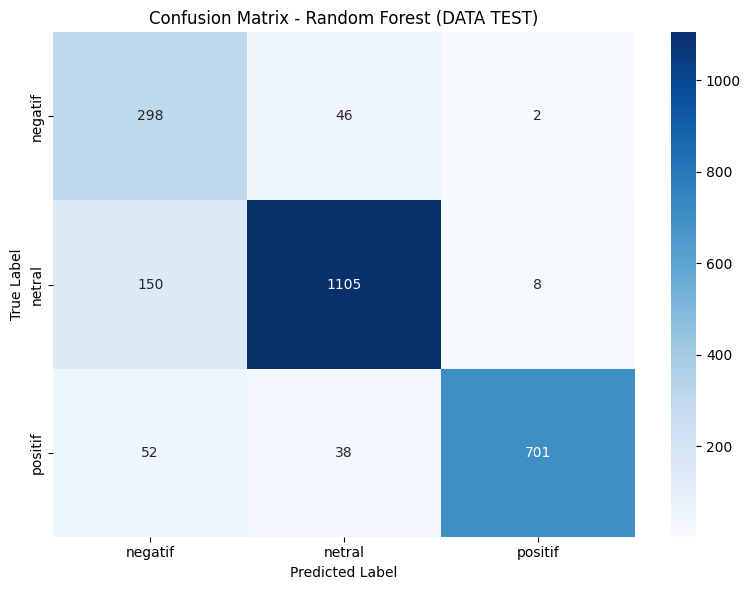

In [20]:
# Prediksi
y_pred_rf = rf_model.predict(X_test_tfidf)

# Evaluasi Random Forest
print("EVALUASI MODEL RANDOM FOREST (DATA TEST):")
print("-" * 70)
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf, average='weighted', zero_division=0)
rec_rf = recall_score(y_test, y_pred_rf, average='weighted', zero_division=0)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted', zero_division=0)

print(f"Accuracy:  {acc_rf:.4f}")
print(f"Precision: {prec_rf:.4f}")
print(f"Recall:    {rec_rf:.4f}")
print(f"F1-Score:  {f1_rf:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['negatif', 'netral', 'positif'],
            yticklabels=['negatif', 'netral', 'positif'])
plt.title('Confusion Matrix - Random Forest (DATA TEST)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

Top 15 Feature Importance (Random Forest):
feature  importance
   lama    0.049052
  bagus    0.040703
 mantap    0.040048
  mahal    0.033237
   baik    0.030217
  tidak    0.029540
  susah    0.028515
 driver    0.024506
  mudah    0.019706
  batal    0.019636
  cepat    0.019065
 kecewa    0.017009
padahal    0.016592
    nya    0.015122
  pesan    0.014306




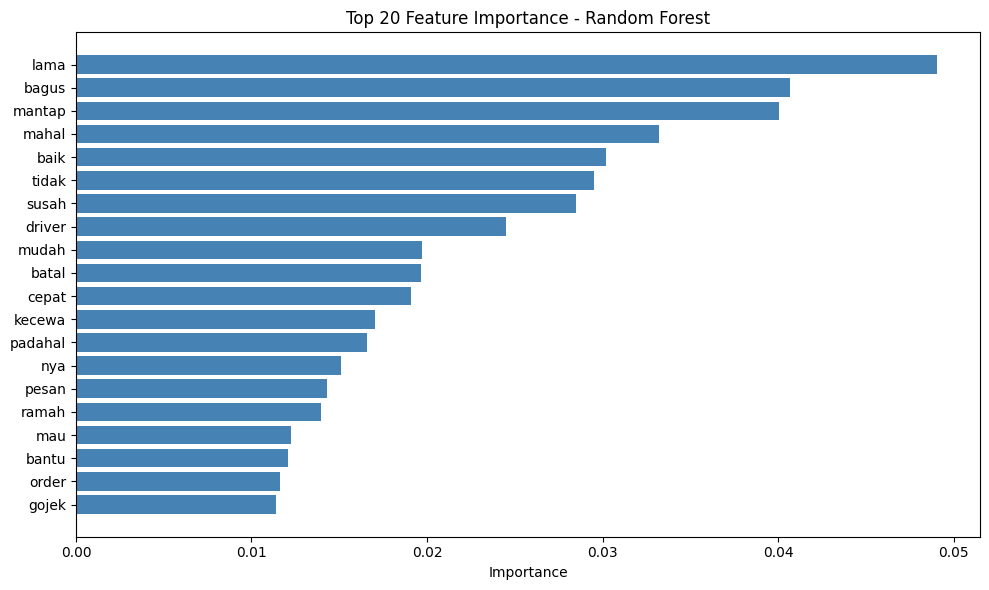

In [21]:
# Feature Importance
print("Top 15 Feature Importance (Random Forest):")
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)
print(feature_importance.head(15).to_string(index=False))
print("\n")

# Visualisasi Feature Importance
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importance - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()

EVALUASI MODEL RANDOM FOREST (DATA TRAINING):
----------------------------------------------------------------------
Accuracy:  0.9181
Precision: 0.9198
Recall:    0.9181
F1-Score:  0.9186

Classification Report:
              precision    recall  f1-score   support

     negatif       0.88      0.92      0.90      5054
      netral       0.89      0.90      0.89      5054
     positif       0.99      0.94      0.96      5054

    accuracy                           0.92     15162
   macro avg       0.92      0.92      0.92     15162
weighted avg       0.92      0.92      0.92     15162



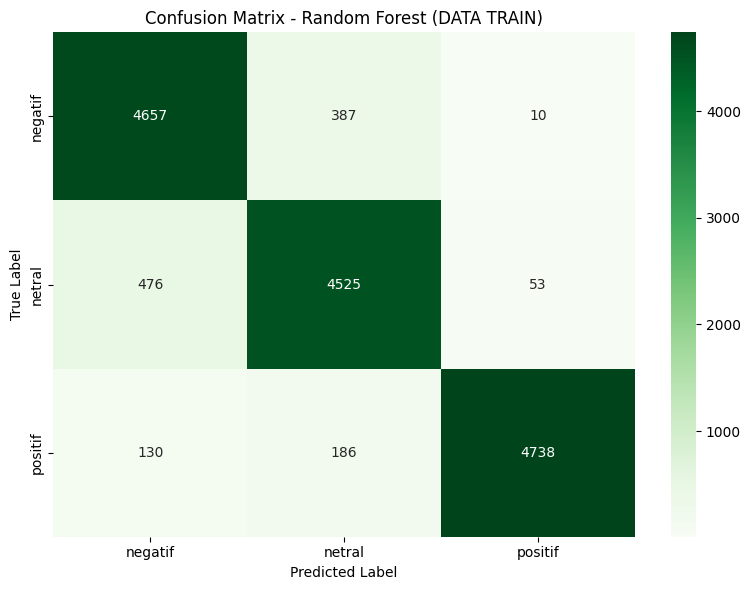

In [22]:
# Prediksi pada data training
y_pred_train_rf = rf_model.predict(X_train_smote)

print("EVALUASI MODEL RANDOM FOREST (DATA TRAINING):")
print("-" * 70)

acc_train_rf = accuracy_score(y_train_smote, y_pred_train_rf)
prec_train_rf = precision_score(y_train_smote, y_pred_train_rf, average='weighted', zero_division=0)
rec_train_rf = recall_score(y_train_smote, y_pred_train_rf, average='weighted', zero_division=0)
f1_train_rf = f1_score(y_train_smote, y_pred_train_rf, average='weighted', zero_division=0)

print(f"Accuracy:  {acc_train_rf:.4f}")
print(f"Precision: {prec_train_rf:.4f}")
print(f"Recall:    {rec_train_rf:.4f}")
print(f"F1-Score:  {f1_train_rf:.4f}\n")

print("Classification Report:")
print(classification_report(y_train_smote, y_pred_train_rf, zero_division=0))

# Confusion Matrix
cm_train_rf = confusion_matrix(y_train_smote, y_pred_train_rf, labels=['negatif', 'netral', 'positif'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=['negatif', 'netral', 'positif'],
            yticklabels=['negatif', 'netral', 'positif'])
plt.title('Confusion Matrix - Random Forest (DATA TRAIN)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


# **7. Skema 2 (Word2Vec, SMOTE, dan LSTM)**

## 7.1 Word2Vec Embedding

In [23]:
# Tokenisasi teks menjadi list of words
print("Tokenisasi teks untuk Word2Vec...")
X_train_tokens = [text.split() for text in X_train]
X_test_tokens = [text.split() for text in X_test]

print("Contoh tokenisasi:")
for i, tokens in enumerate(X_train_tokens[:5]):
    print(f"   {i+1}. {tokens[:10]}...")
print("\n")

Tokenisasi teks untuk Word2Vec...
Contoh tokenisasi:
   1. ['guna', 'banget', 'app', 'nya', 'buat', 'aku', 'yg', 'riweh']...
   2. ['terimakasih', 'atas', 'layan', 'baik']...
   3. ['cari', 'drivernya', 'sering', 'cancle', 'padahal', 'udah', 'nungguin', 'lama', 'susah', 'cari']...
   4. ['kalo', 'mau', 'isi', 'pulsa', 'pulsa', 'nya', 'sedia']...
   5. ['cepat', 'sopan']...




In [24]:
# Training Word2Vec model
print("Training Word2Vec model...")
w2v_model = Word2Vec(
    sentences=X_train_tokens,
    vector_size=100,  
    window=5,         
    min_count=2,      
    workers=4,
    sg=1,            
    epochs=10
)

print(f"Word2Vec Model Info:")
print(f"Vocabulary size: {len(w2v_model.wv)}")
print(f"Vector size: {w2v_model.wv.vector_size}")
print(f"Total words trained: {w2v_model.corpus_total_words}\n")


Training Word2Vec model...
Word2Vec Model Info:
Vocabulary size: 3012
Vector size: 100
Total words trained: 79087



In [25]:
# Fungsi untuk membuat embedding matrix
def text_to_sequence(tokens, word2vec_model, max_length):
    sequences = []
    for text_tokens in tokens:
        sequence = []
        for word in text_tokens:
            if word in word2vec_model.wv:
                # Gunakan index dari vocabulary
                sequence.append(word2vec_model.wv.key_to_index[word])
        sequences.append(sequence)
    
    # Padding sequences
    padded = pad_sequences(sequences, maxlen=max_length, padding='post')
    return padded

# Tentukan max length
max_length = 100
print(f"Mengkonversi teks ke sequences (max_length={max_length})...")
X_train_seq = text_to_sequence(X_train_tokens, w2v_model, max_length)
X_test_seq = text_to_sequence(X_test_tokens, w2v_model, max_length)
print("Konversi selesai!\n")

print(f"Sequence Shape:")
print(f"Train: {X_train_seq.shape}")
print(f"Test: {X_test_seq.shape}\n")

print("Contoh sequence:")
for i in range(3):
    print(f"   Sample {i+1}: {X_train_seq[i][:20]}...")
print("\n")

Mengkonversi teks ke sequences (max_length=100)...
Konversi selesai!

Sequence Shape:
Train: (9600, 100)
Test: (2400, 100)

Contoh sequence:
   Sample 1: [ 47  14 346   3  25 115   5   0   0   0   0   0   0   0   0   0   0   0
   0   0]...
   Sample 2: [114 353  29   9   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]...
   Sample 3: [ 113   39   60 1107   22   18  636   13   64  113    1    0    0    0
    0    0    0    0    0    0]...




In [26]:
# Membuat embedding matrix
vocab_size = len(w2v_model.wv) + 1
embedding_dim = w2v_model.wv.vector_size

print("Membuat embedding matrix")
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, idx in w2v_model.wv.key_to_index.items():
    embedding_matrix[idx] = w2v_model.wv[word]

print(f"Embedding Matrix Shape: {embedding_matrix.shape}\n")

Membuat embedding matrix
Embedding Matrix Shape: (3013, 100)



In [27]:
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Konversi ke categorical 
num_classes = len(label_encoder.classes_)
y_train_cat = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_cat = to_categorical(y_test_encoded, num_classes=num_classes)

## 7.2 Menerapkan SMOTE

In [28]:
# Menerapkan SMOTE
print("Distribusi sebelum SMOTE:")
print(pd.Series(y_train_encoded).value_counts().sort_index())
print("\n")

# Apply SMOTE 
min_class_lstm = pd.Series(y_train_encoded).value_counts().min()
k_neighbors_lstm = min(5, min_class_lstm - 1) if min_class_lstm > 1 else 1

smote_lstm = SMOTE(random_state=42, k_neighbors=k_neighbors_lstm)
X_train_seq_smote, y_train_seq_smote = smote_lstm.fit_resample(X_train_seq, y_train_encoded)

print("Distribusi setelah SMOTE:")
smote_lstm_dist = pd.Series(y_train_seq_smote).value_counts().sort_index()
for idx, count in smote_lstm_dist.items():
    label_name = label_encoder.classes_[idx]
    print(f"   {label_name} ({idx}): {count} ({count/len(y_train_seq_smote)*100:.2f}%)")
print("\n")

print(f"Sebelum SMOTE: {X_train_seq.shape[0]} sampel")
print(f"Setelah SMOTE: {X_train_seq_smote.shape[0]} sampel")

Distribusi sebelum SMOTE:
0    1382
1    5054
2    3164
dtype: int64


Distribusi setelah SMOTE:
   negatif (0): 5054 (33.33%)
   netral (1): 5054 (33.33%)
   positif (2): 5054 (33.33%)


Sebelum SMOTE: 9600 sampel
Setelah SMOTE: 15162 sampel


y_train_seq_smote_cat shape: (15162, 3)



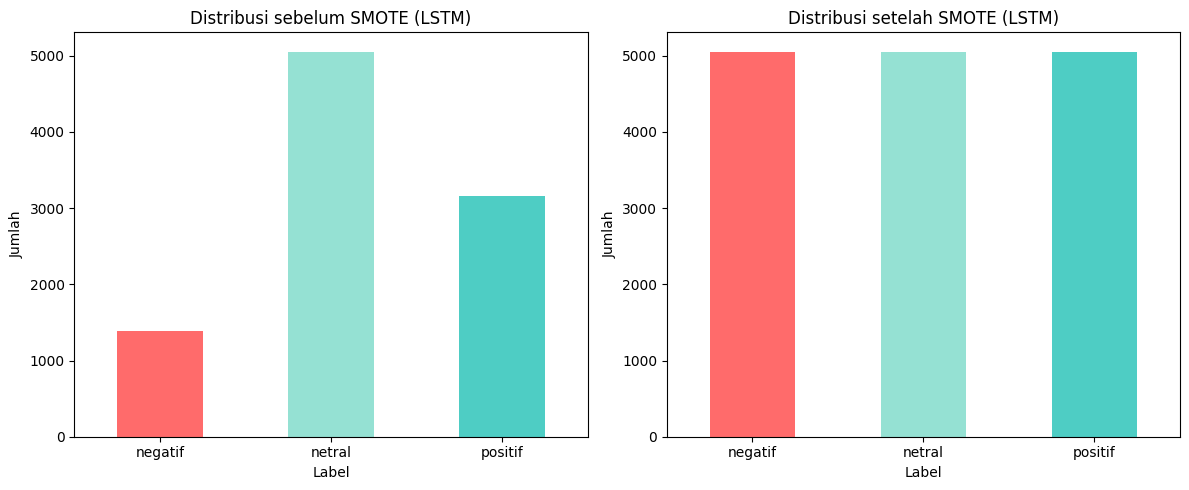

In [29]:
# Konversi hasil SMOTE ke categorical
y_train_seq_smote_cat = to_categorical(y_train_seq_smote, num_classes=num_classes)
print(f"y_train_seq_smote_cat shape: {y_train_seq_smote_cat.shape}\n")

# Visualisasi perbandingan
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE
pd.Series(y_train_encoded).value_counts().sort_index().plot(
    kind='bar', ax=axes[0], color=['#ff6b6b', '#95e1d3', '#4ecdc4']
)
axes[0].set_title('Distribusi sebelum SMOTE (LSTM)')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Jumlah')
axes[0].set_xticklabels(label_encoder.classes_, rotation=0)

# After SMOTE
pd.Series(y_train_seq_smote).value_counts().sort_index().plot(
    kind='bar', ax=axes[1], color=['#ff6b6b', '#95e1d3', '#4ecdc4']
)
axes[1].set_title('Distribusi setelah SMOTE (LSTM)')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Jumlah')
axes[1].set_xticklabels(label_encoder.classes_, rotation=0)

plt.tight_layout()

## 7.3 Modelling and Training (LSTM)

In [30]:
lstm_model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=False
    ),
    
    Bidirectional(LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
    Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)),
    
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    
    Dense(num_classes, activation='softmax')
])

# Compile model
optimizer = Adam(learning_rate=0.0008)
lstm_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
print("LSTM Model Architecture:")
lstm_model.summary()

LSTM Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       301,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 301,300 (1.15 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 301,300 (1.15 MB)

In [33]:
# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# Training
print("Training LSTM model...")

history = lstm_model.fit(
    X_train_seq_smote, y_train_seq_smote_cat,
    validation_data=(X_test_seq, y_test_cat),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Training LSTM model...
Epoch 1/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 209s 442ms/step - accuracy: 0.8475 - loss: 0.4005 - val_accuracy: 0.8654 - val_loss: 0.3169 - learning_rate: 8.0000e-04
Epoch 2/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 213s 450ms/step - accuracy: 0.8512 - loss: 0.3875 - val_accuracy: 0.9233 - val_loss: 0.2276 - learning_rate: 8.0000e-04
Epoch 3/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 219s 461ms/step - accuracy: 0.8635 - loss: 0.3622 - val_accuracy: 0.9321 - val_loss: 0.2217 - learning_rate: 8.0000e-04
Epoch 4/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 220s 465ms/step - accuracy: 0.8716 - loss: 0.3362 - val_accuracy: 0.9421 - val_loss: 0.2013 - learning_rate: 8.0000e-04
Epoch 5/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 219s 463ms/step - accuracy: 0.8665 - loss: 0.3382 - val_accuracy: 0.9217 - val_loss: 0.2252 - learning_rate: 8.0000e-04
Epoch 6/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 221s 466ms/step - accuracy: 0.8805 - loss: 0.3186 - val_accuracy: 0.9142 - val_loss: 0.2428 - learning_rate: 8.0000e-04
Epoch 7/30
474/47

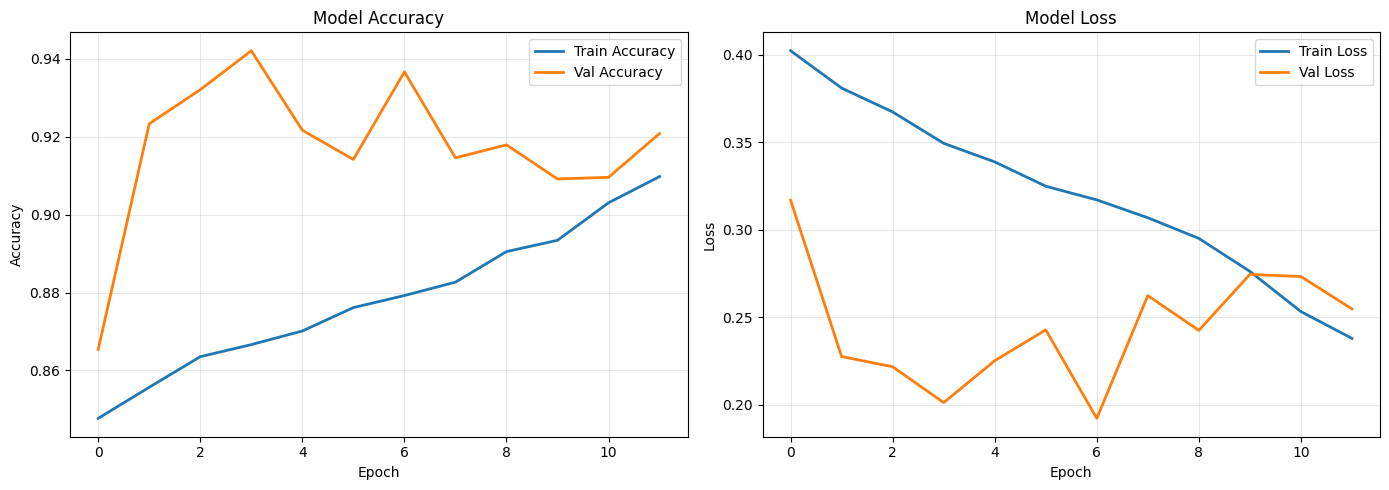

In [34]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

METRIK EVALUASI LSTM (DATA TEST):
Accuracy:  0.9367
Precision: 0.9362
Recall:    0.9367
F1-Score:  0.9364

Classification Report:
              precision    recall  f1-score   support

     negatif       0.83      0.81      0.82       346
      netral       0.95      0.95      0.95      1263
     positif       0.97      0.97      0.97       791

    accuracy                           0.94      2400
   macro avg       0.91      0.91      0.91      2400
weighted avg       0.94      0.94      0.94      2400



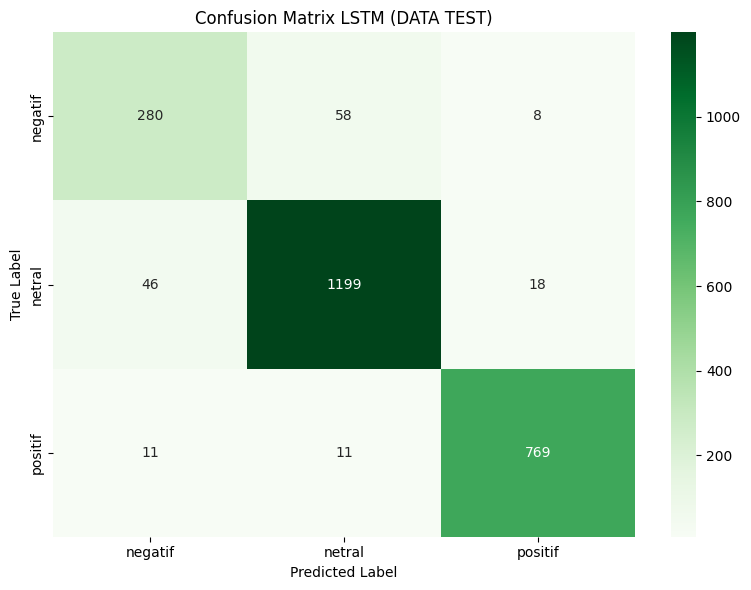

In [35]:
# Prediksi pada data test
y_pred_lstm_prob = lstm_model.predict(X_test_seq, verbose=0)
y_pred_lstm_encoded = np.argmax(y_pred_lstm_prob, axis=1)
y_pred_lstm = label_encoder.inverse_transform(y_pred_lstm_encoded)

# Metrik Evaluasi
acc_lstm = accuracy_score(y_test, y_pred_lstm)
prec_lstm = precision_score(y_test, y_pred_lstm, average='weighted', zero_division=0)
rec_lstm = recall_score(y_test, y_pred_lstm, average='weighted', zero_division=0)
f1_lstm = f1_score(y_test, y_pred_lstm, average='weighted', zero_division=0)

print("METRIK EVALUASI LSTM (DATA TEST):")
print(f"Accuracy:  {acc_lstm:.4f}")
print(f"Precision: {prec_lstm:.4f}")
print(f"Recall:    {rec_lstm:.4f}")
print(f"F1-Score:  {f1_lstm:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred_lstm, zero_division=0))

# Confusion Matrix
cm_lstm = confusion_matrix(y_test, y_pred_lstm, labels=['negatif', 'netral', 'positif'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['negatif', 'netral', 'positif'],
            yticklabels=['negatif', 'netral', 'positif'])
plt.title('Confusion Matrix LSTM (DATA TEST)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

METRIK EVALUASI LSTM (DATA TRAIN):
Accuracy:  0.8973
Precision: 0.8991
Recall:    0.8973
F1-Score:  0.8967

Classification Report:
              precision    recall  f1-score   support

     negatif       0.89      0.86      0.87      5054
      netral       0.87      0.98      0.92      5054
     positif       0.94      0.86      0.90      5054

    accuracy                           0.90     15162
   macro avg       0.90      0.90      0.90     15162
weighted avg       0.90      0.90      0.90     15162



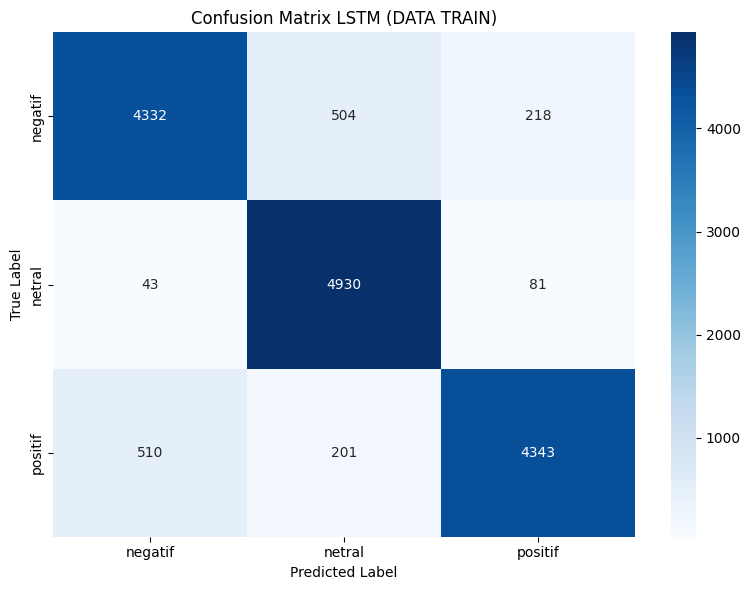

In [36]:
# Prediksi pada data train 
y_pred_lstm_train_prob = lstm_model.predict(X_train_seq_smote, verbose=0)
y_pred_lstm_train_encoded = np.argmax(y_pred_lstm_train_prob, axis=1)
y_pred_lstm_train = label_encoder.inverse_transform(y_pred_lstm_train_encoded)
y_train_actual = label_encoder.inverse_transform(y_train_seq_smote)

# Metrik Evaluasi
acc_lstm_train = accuracy_score(y_train_actual, y_pred_lstm_train)
prec_lstm_train = precision_score(y_train_actual, y_pred_lstm_train, average='weighted', zero_division=0)
rec_lstm_train = recall_score(y_train_actual, y_pred_lstm_train, average='weighted', zero_division=0)
f1_lstm_train = f1_score(y_train_actual, y_pred_lstm_train, average='weighted', zero_division=0)

print("METRIK EVALUASI LSTM (DATA TRAIN):")
print(f"Accuracy:  {acc_lstm_train:.4f}")
print(f"Precision: {prec_lstm_train:.4f}")
print(f"Recall:    {rec_lstm_train:.4f}")
print(f"F1-Score:  {f1_lstm_train:.4f}\n")

print("Classification Report:")
print(classification_report(y_train_actual, y_pred_lstm_train, zero_division=0))

# Confusion Matrix 
cm_lstm_train = confusion_matrix(y_train_actual, y_pred_lstm_train, 
                                 labels=['negatif', 'netral', 'positif'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm_train, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['negatif', 'netral', 'positif'],
            yticklabels=['negatif', 'netral', 'positif'])
plt.title('Confusion Matrix LSTM (DATA TRAIN)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

# **8. Skema 3 (TF-IDF, SMOTE, dan XGBoost)**

In [37]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder as LE_XGB

# Encoding untuk XGBoost
print("Encoding labels untuk XGBoost...")
le_xgb = LE_XGB()
y_train_smote_xgb = le_xgb.fit_transform(y_train_smote)
y_test_xgb = le_xgb.transform(y_test)

# Distribusi label
print("Distribusi Label untuk XGBoost:")
print("TRAIN (setelah SMOTE):")
for idx, label in enumerate(le_xgb.classes_):
    count = (y_train_smote_xgb == idx).sum()
    print(f"   {label} ({idx}): {count} ({count/len(y_train_smote_xgb)*100:.2f}%)")

Encoding labels untuk XGBoost...
Distribusi Label untuk XGBoost:
TRAIN (setelah SMOTE):
   negatif (0): 5054 (33.33%)
   netral (1): 5054 (33.33%)
   positif (2): 5054 (33.33%)


## 8.1 Modelling and Training (XGBoost)

In [ ]:
xgb_model = XGBClassifier(
    n_estimators=400,           
    max_depth=6,                
    learning_rate=0.05,         
    subsample=0.85,             
    colsample_bytree=0.9,       
    min_child_weight=5,         
    gamma=0.2,                  
    reg_alpha=0.2,              
    reg_lambda=1.2,             
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='mlogloss'      
)

# Training XGBoost
xgb_model.fit(X_train_smote, y_train_smote_xgb, verbose=50)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
              n_jobs=-1, num_parallel_tree=None, objective='multi:softprob', ...)

Top 20 Feature Importance (XGBoost):
feature  importance
 mantap    0.042427
   lama    0.036498
  mahal    0.036494
  tidak    0.034437
  mudah    0.032134
  susah    0.032070
  bagus    0.030275
 kecewa    0.029426
   good    0.026951
  cepat    0.020952
  batal    0.020715
  jelek    0.019515
  bantu    0.019065
    top    0.017768
   baik    0.017546
   puas    0.017366
  ramah    0.017203
 nyaman    0.015543
  ribet    0.014882
  buruk    0.014818




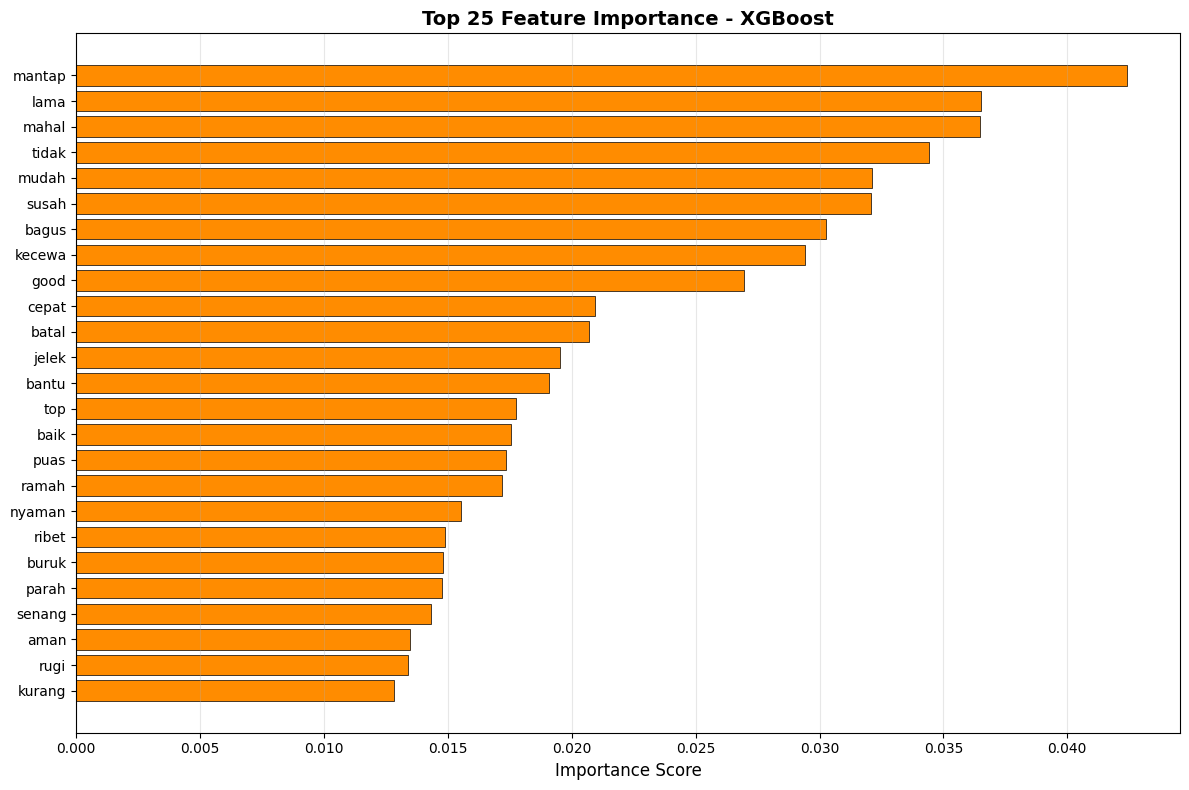

In [39]:
# Feature Importance
print("Top 20 Feature Importance (XGBoost):")
feature_importance_xgb = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance_xgb.head(20).to_string(index=False))
print("\n")

# Visualisasi Feature Importance
plt.figure(figsize=(12, 8))
top_features_xgb = feature_importance_xgb.head(25)
plt.barh(range(len(top_features_xgb)), top_features_xgb['importance'], 
         color='darkorange', edgecolor='black', linewidth=0.5)
plt.yticks(range(len(top_features_xgb)), top_features_xgb['feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 25 Feature Importance - XGBoost', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

## 8.2 Evaluasi

EVALUASI XGBoost (DATA TEST):
Accuracy:  0.9788 (97.88%)
Precision: 0.9793
Recall:    0.9788
F1-Score:  0.9789

Classification Report:
              precision    recall  f1-score   support

     negatif       0.93      0.98      0.95       346
      netral       0.99      0.98      0.98      1263
     positif       0.98      0.98      0.98       791

    accuracy                           0.98      2400
   macro avg       0.97      0.98      0.97      2400
weighted avg       0.98      0.98      0.98      2400



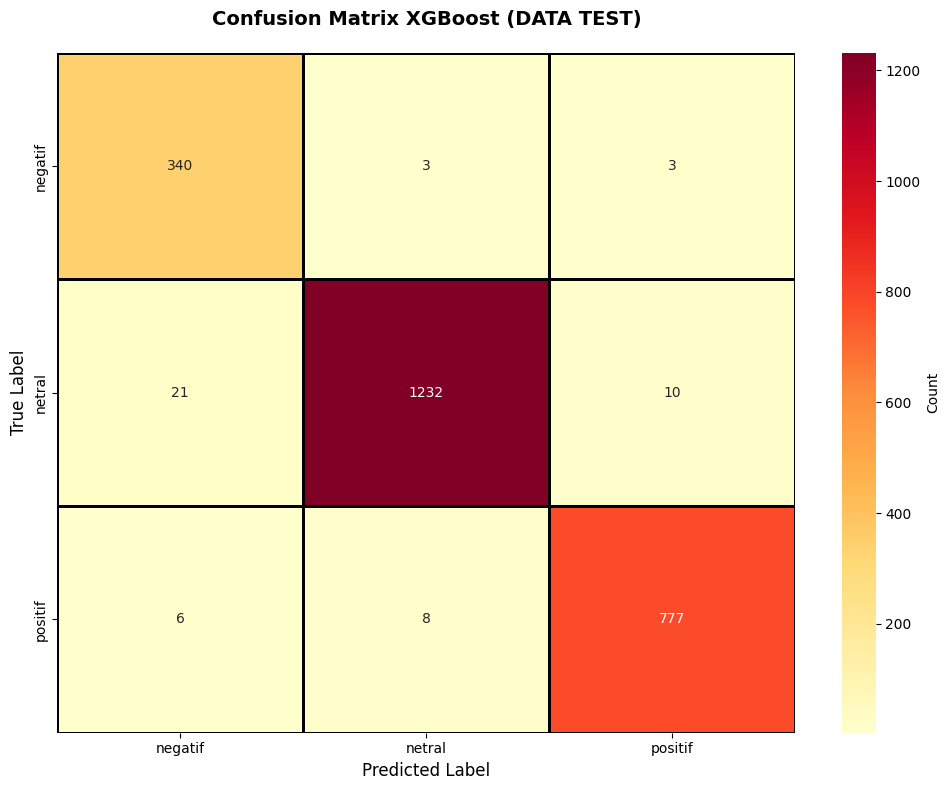

In [40]:
# Prediksi pada data test
y_pred_xgb_encoded = xgb_model.predict(X_test_tfidf)
y_pred_xgb = le_xgb.inverse_transform(y_pred_xgb_encoded)

# Metrik Evaluasi
acc_xgb = accuracy_score(y_test, y_pred_xgb)
prec_xgb = precision_score(y_test, y_pred_xgb, average='weighted', zero_division=0)
rec_xgb = recall_score(y_test, y_pred_xgb, average='weighted', zero_division=0)
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted', zero_division=0)

print("EVALUASI XGBoost (DATA TEST):")
print(f"Accuracy:  {acc_xgb:.4f} ({acc_xgb*100:.2f}%)")
print(f"Precision: {prec_xgb:.4f}")
print(f"Recall:    {rec_xgb:.4f}")
print(f"F1-Score:  {f1_xgb:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred_xgb, zero_division=0))

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb, labels=['negatif', 'netral', 'positif'])

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_xgb, 
    annot=True, 
    fmt='d', 
    cmap='YlOrRd',
    xticklabels=['negatif', 'netral', 'positif'],
    yticklabels=['negatif', 'netral', 'positif'],
    cbar_kws={'label': 'Count'},
    linewidths=1,
    linecolor='black'
)
plt.title('Confusion Matrix XGBoost (DATA TEST)', 
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()

EVALUASI XGBoost (DATA TRAIN):
Accuracy:  0.9895 (98.95%)
Precision: 0.9896
Recall:    0.9895
F1-Score:  0.9895

Classification Report:
              precision    recall  f1-score   support

     negatif       0.99      1.00      0.99      5054
      netral       0.99      0.98      0.99      5054
     positif       0.99      1.00      0.99      5054

    accuracy                           0.99     15162
   macro avg       0.99      0.99      0.99     15162
weighted avg       0.99      0.99      0.99     15162



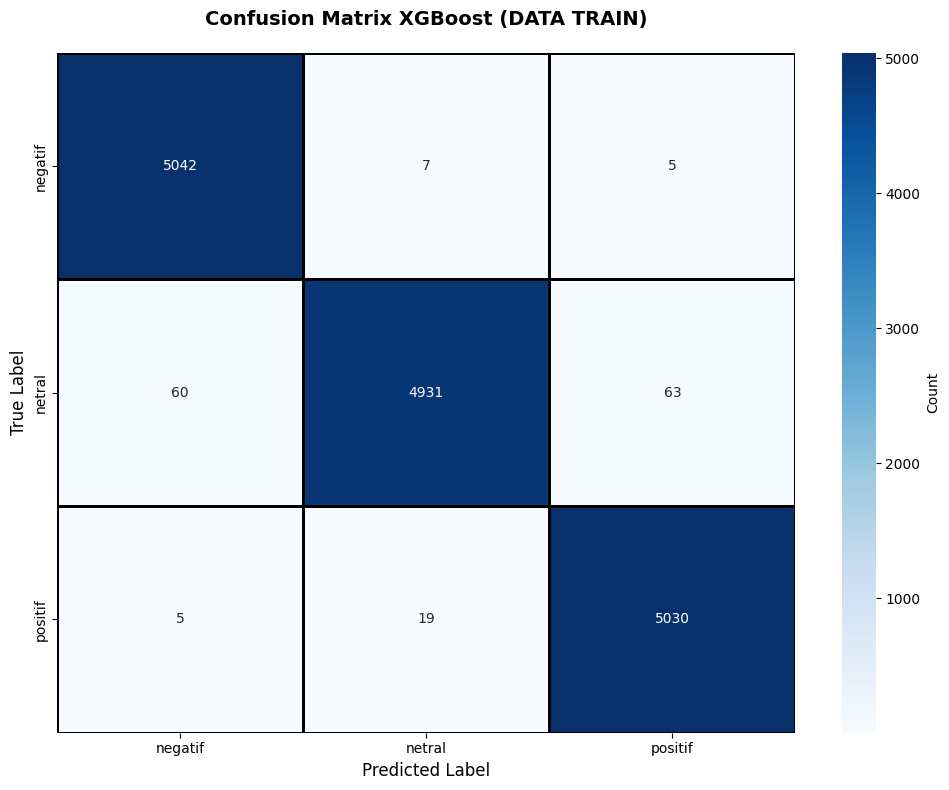

In [41]:
# Prediksi pada data train
y_pred_xgb_train_encoded = xgb_model.predict(X_train_smote)
y_pred_xgb_train = le_xgb.inverse_transform(y_pred_xgb_train_encoded)
y_train_actual_xgb = le_xgb.inverse_transform(y_train_smote_xgb)

# Metrik Evaluasi
acc_xgb_train = accuracy_score(y_train_actual_xgb, y_pred_xgb_train)
prec_xgb_train = precision_score(y_train_actual_xgb, y_pred_xgb_train, average='weighted', zero_division=0)
rec_xgb_train = recall_score(y_train_actual_xgb, y_pred_xgb_train, average='weighted', zero_division=0)
f1_xgb_train = f1_score(y_train_actual_xgb, y_pred_xgb_train, average='weighted', zero_division=0)

print("EVALUASI XGBoost (DATA TRAIN):")
print(f"Accuracy:  {acc_xgb_train:.4f} ({acc_xgb_train*100:.2f}%)")
print(f"Precision: {prec_xgb_train:.4f}")
print(f"Recall:    {rec_xgb_train:.4f}")
print(f"F1-Score:  {f1_xgb_train:.4f}\n")

print("Classification Report:")
print(classification_report(y_train_actual_xgb, y_pred_xgb_train, zero_division=0))

# Confusion Matrix
cm_xgb_train = confusion_matrix(y_train_actual_xgb, y_pred_xgb_train, 
                                 labels=['negatif', 'netral', 'positif'])

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_xgb_train, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=['negatif', 'netral', 'positif'],
    yticklabels=['negatif', 'netral', 'positif'],
    cbar_kws={'label': 'Count'},
    linewidths=1,
    linecolor='black'
)
plt.title('Confusion Matrix XGBoost (DATA TRAIN)', 
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()

# **9. Save Models untuk File Inference**

In [43]:
os.makedirs('saved_models', exist_ok=True)

# Save TF-IDF Vectorizer
joblib.dump(vectorizer, 'saved_models/tfidf_vectorizer.pkl')
print("TF-IDF Vectorizer disimpan")

# Save Random Forest Model
joblib.dump(rf_model, 'saved_models/random_forest_model.pkl')
print("Random Forest Model disimpan")

# Save label classes untuk RF (opsional, untuk validasi)
with open('saved_models/rf_label_classes.pkl', 'wb') as f:
    pickle.dump(label_encoder.classes_.tolist(), f)
print("Label classes disimpan\n")

# Save Word2Vec Model
w2v_model.save('saved_models/word2vec_model.bin')
print("Word2Vec Model disimpan")

# Save LSTM Model
lstm_model.save('saved_models/lstm_model.h5')
print("LSTM Model disimpan")

# Save Label Encoder
joblib.dump(label_encoder, 'saved_models/label_encoder.pkl')
print("Label Encoder disimpan")

# Save config untuk LSTM
lstm_config = {
    'max_length': max_length,
    'vocab_size': vocab_size,
    'embedding_dim': embedding_dim
}
with open('saved_models/lstm_config.pkl', 'wb') as f:
    pickle.dump(lstm_config, f)
print("LSTM Config disimpan\n")

# Save XGBoost Model
xgb_model.save_model('saved_models/xgboost_model.json')
print("XGBoost Model disimpan")

# Save Label Encoder untuk XGBoost
joblib.dump(le_xgb, 'saved_models/label_encoder_xgb.pkl')
print("Label Encoder XGBoost disimpan")

# Save Stemmer & Stopword Remover
preprocessing_config = {
    'use_sastrawi': True,
    'max_features': 5000,
    'ngram_range': (1, 2)
}

with open('saved_models/preprocessing_config.pkl', 'wb') as f:
    pickle.dump(preprocessing_config, f)
print("Preprocessing Config disimpan\n")

TF-IDF Vectorizer disimpan
Random Forest Model disimpan
Label classes disimpan

Word2Vec Model disimpan
LSTM Model disimpan
Label Encoder disimpan
LSTM Config disimpan

XGBoost Model disimpan
Label Encoder XGBoost disimpan
Preprocessing Config disimpan

